# The Prophet Forecasting Model
We use a decomposable time series model with three main model components: trend, seasonality, and holidays. They are combined in the following equation:  y(t) = g(t) + s(t) + h(t) + εt


g(t): piecewise linear or logistic growth curve for modelling non-periodic changes in time series

s(t): periodic changes (e.g. weekly/yearly seasonality)

h(t): effects of holidays (user provided) with irregular schedules

εt: error term accounts for any unusual changes not accommodated by the model

Using time as a regressor, Prophet is trying to fit several linear and non linear functions of time as components. Modeling seasonality as an additive component is the same approach taken by exponential smoothing in Holt-Winters technique . We are, in effect, framing the forecasting problem as a curve-fitting exercise rather than looking explicitly at the time based dependence of each observation within a time series.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

!pip install prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet

plt.style.use('fivethirtyeight')


# Insertion of cleaned dataset

In [80]:
df=pd.read_csv('asia_clean.csv')

In [81]:
df.head()

,Unnamed: 0,dt,AverageTemperature,AverageTemperatureUncertainty,Country,Year
0,0,1990-01-01,1.558,0.460,Afghanistan,1990
1,1,1990-02-01,3.669,0.244,Afghanistan,1990
2,2,1990-03-01,8.402,0.311,Afghanistan,1990
3,3,1990-04-01,14.457,0.231,Afghanistan,1990
4,4,1990-05-01,22.442,0.316,Afghanistan,1990


**We decided to use China as an example**

In [92]:
china = df.loc[df['Country'] == 'China', ['dt','AverageTemperature']]
china.columns = ['Date','Temp']
china['Date'] = pd.to_datetime(china['Date'])
china.reset_index(drop=True, inplace=True)
china.set_index('Date', inplace=True)

china.head()

,Temp
Date,
1990-01-01,-7.151
1990-02-01,-3.761
1990-03-01,2.889
1990-04-01,7.676
1990-05-01,13.765


Lets take a look at the temperature variation in China in our range set (1990-2013)

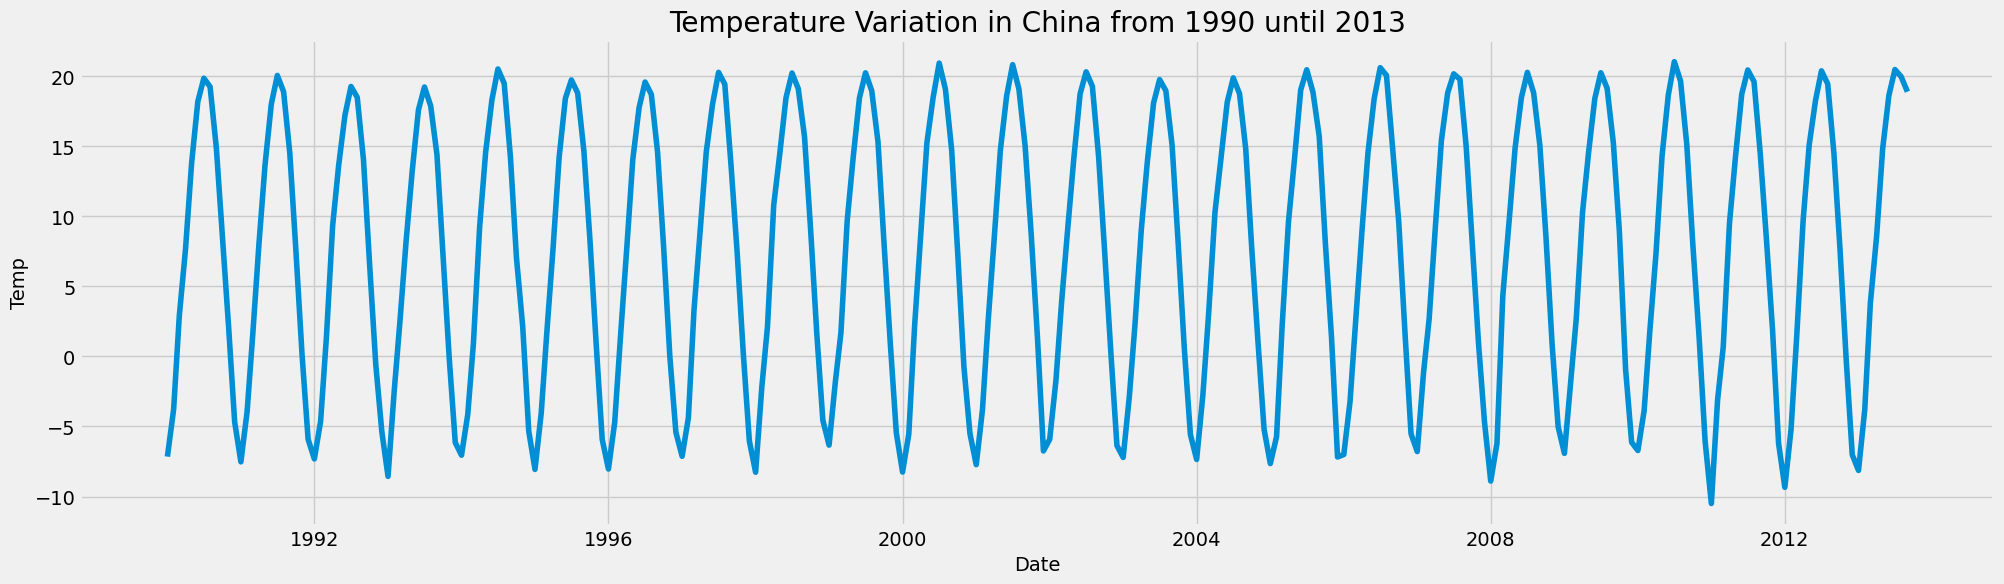

In [83]:
plt.figure(figsize=(22,6))
sns.lineplot(x=china.index, y=china['Temp'])
plt.title('Temperature Variation in China from 1990 until 2013')
plt.show()

# Splitting between train and test set

In [125]:
num_train= round(len(china) * 0.75)
train= china.iloc[:num_train]
test= china.iloc[num_train:]

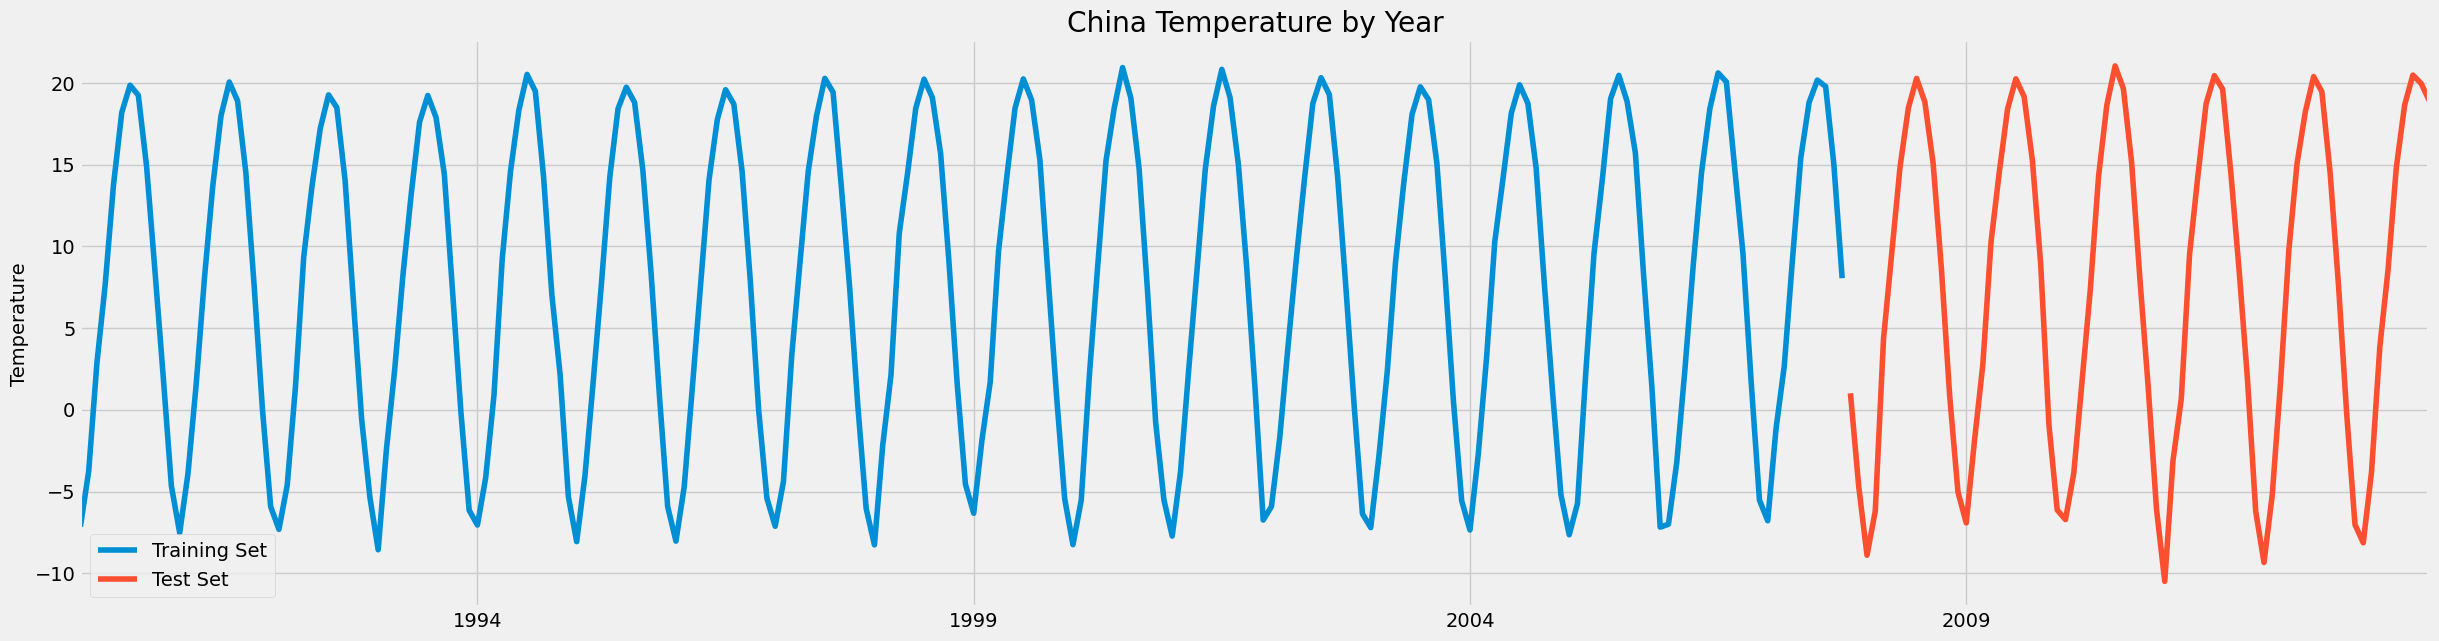

In [126]:
fig, ax= plt.subplots(figsize= (27, 7))
train.plot(
    ax= ax, 
    label= 'Training Set'
)
test.plot(
    ax= ax, 
    label= 'Test Set'
)

ax.set_title('China Temperature by Year')
ax.set_xlabel('')
ax.set_ylabel('Temperature')
ax.legend(['Training Set', 'Test Set'])
plt.show()

**Creating of prophet set to make use of the model**

In [127]:
def create_prophet_set(df): 
    return (df
        .reset_index()
        .rename(columns= {
            'Date': 'ds',
            'Temp': 'y'
        })
    )

train_prophet= create_prophet_set(train)
test_prophet= create_prophet_set(test)

In [128]:
model_prophet= Prophet()
model_prophet.fit(train_prophet)

15:35:14 - cmdstanpy - INFO - Chain [1] start processing
15:35:14 - cmdstanpy - INFO - Chain [1] done processing


In [129]:
preds= model_prophet.predict(test_prophet)

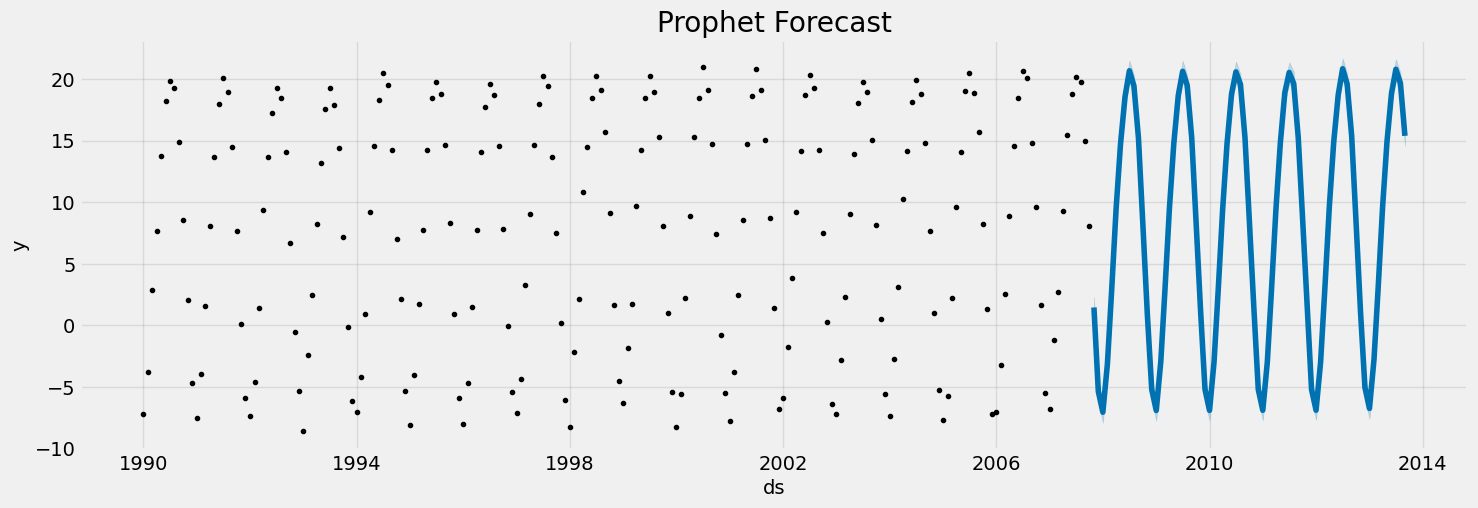

In [144]:
fig, ax= plt.subplots(figsize= (15, 5))
model_prophet.plot(
    preds,
    ax= ax
)
ax.set_title('Prophet Forecast')
plt.show()

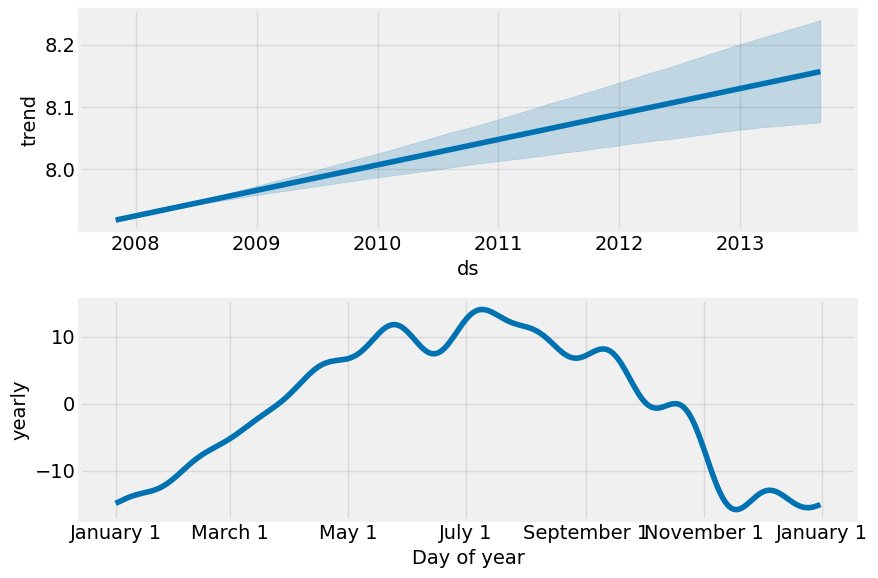

In [131]:
fig= model_prophet.plot_components(preds)
plt.show()

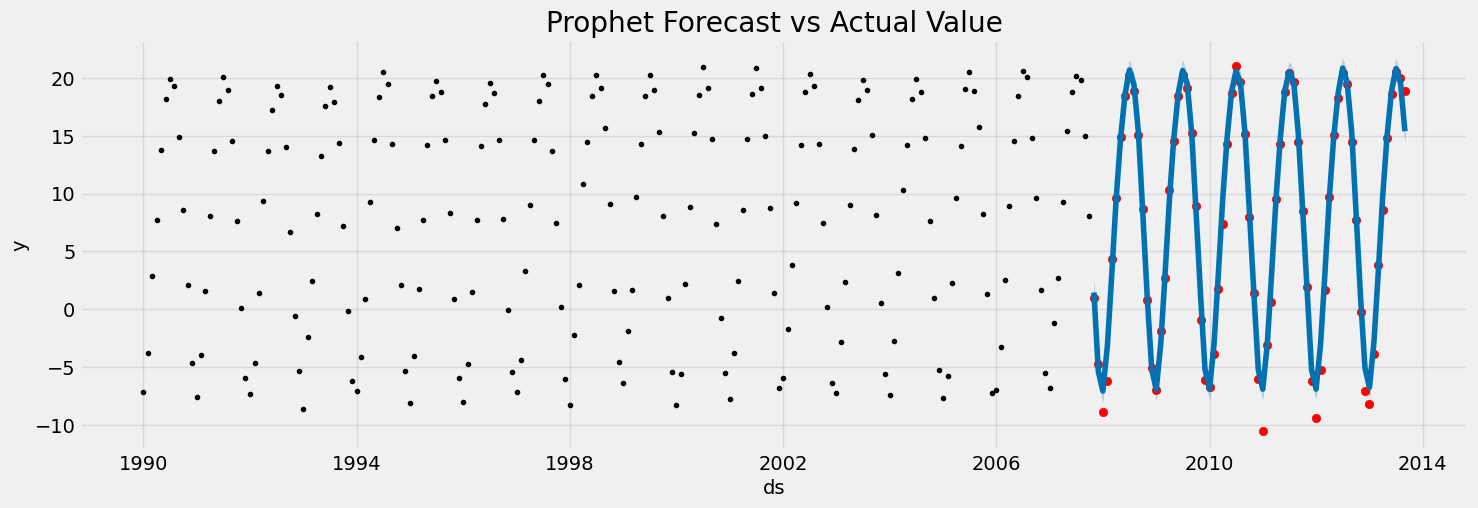

In [132]:
fig, ax= plt.subplots(figsize= (15, 5))
model_prophet.plot(preds, ax= ax)
ax.scatter(test_prophet['ds'], test_prophet['y'], color= 'red')
ax.set_title('Prophet Forecast vs Actual Value')
plt.show()

In [133]:
test_prophet['ds'].min()

Timestamp('2007-11-01 00:00:00')

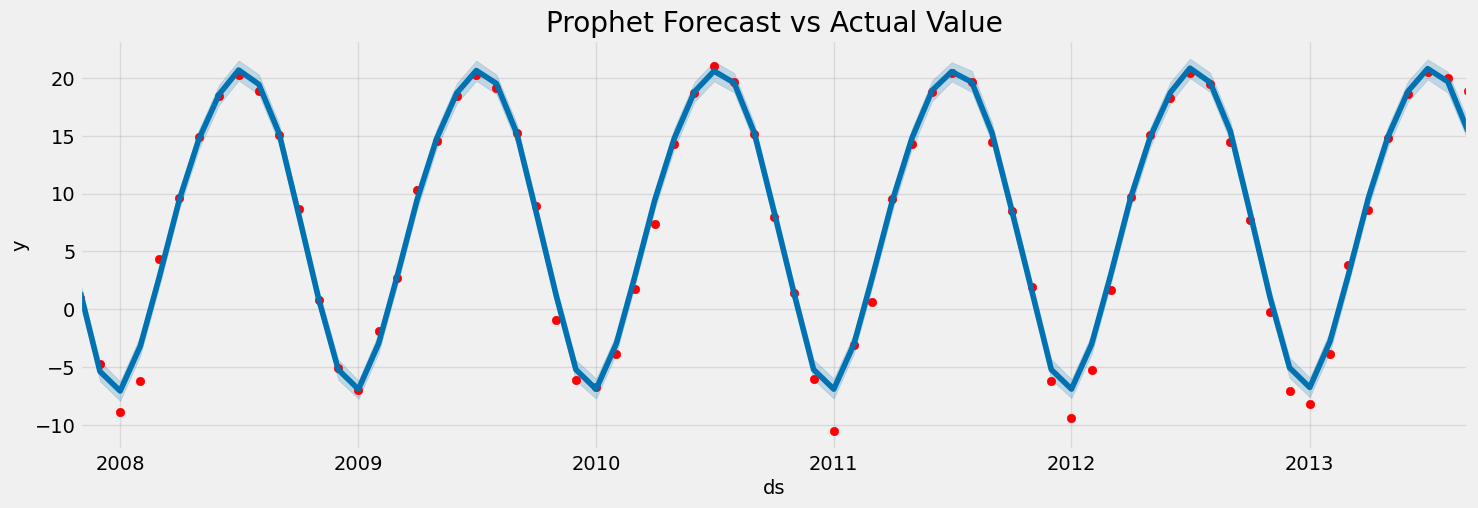

In [138]:
fig, ax= plt.subplots(figsize= (15, 5))
model_prophet.plot(preds, ax= ax)
ax.scatter(test_prophet['ds'], test_prophet['y'], color= 'red')
ax.set_title('Prophet Forecast vs Actual Value')
ax.set_xbound(
    lower= test_prophet['ds'].min(),
    upper= test_prophet['ds'].max()
)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


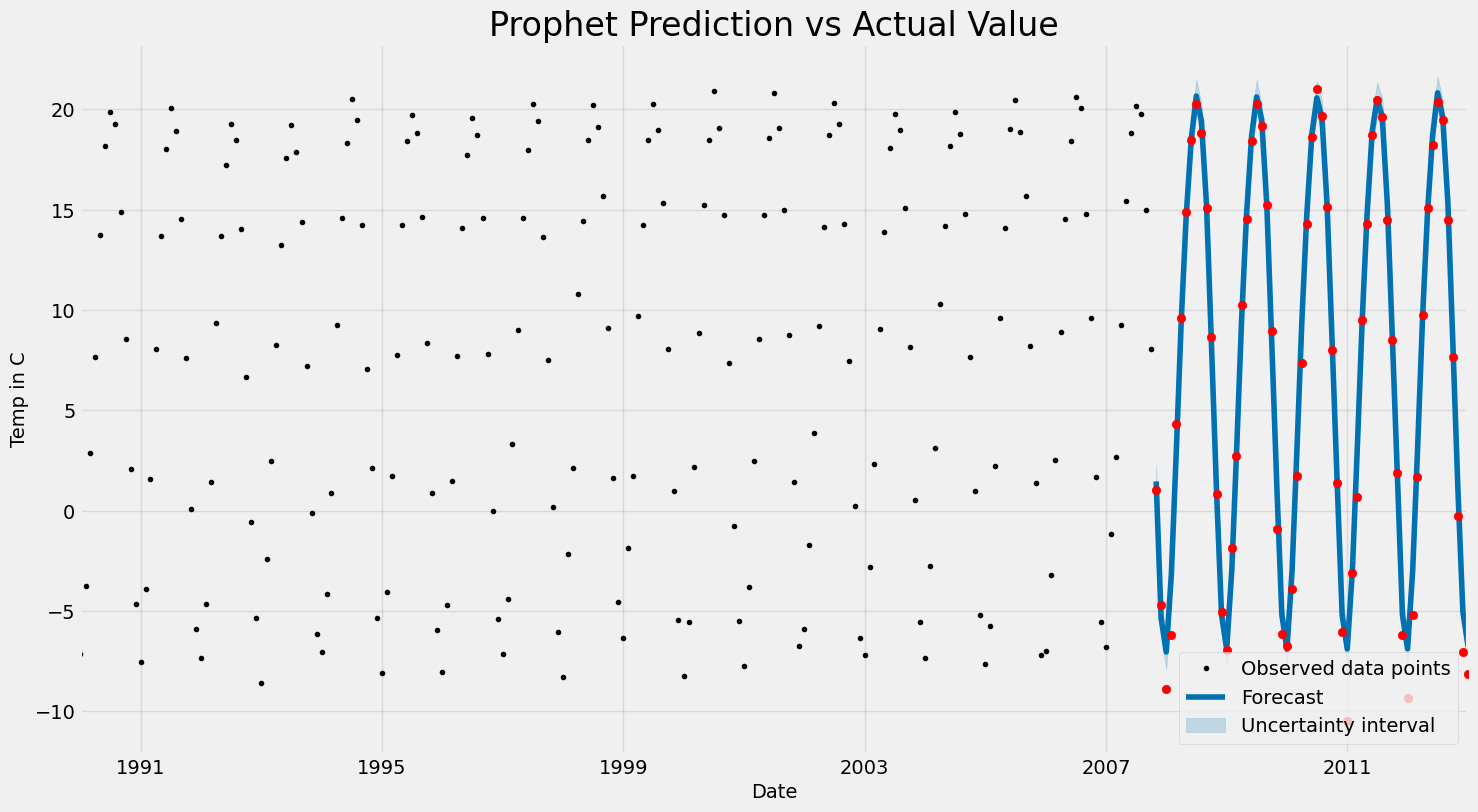

In [139]:
fig, ax= plt.subplots(figsize= (15, 8))

ax.scatter(test_prophet['ds'], test_prophet['y'], color= 'red', zorder= 5)
ax.legend()
model_prophet.plot(preds, ax= ax)

ax.legend()
ax.set_title('Prophet Prediction vs Actual Value', fontsize= 24)
ax.set_xbound(
    lower= pd.to_datetime('1990-01-01'),
    upper= pd.to_datetime('2013-01-01')
)
ax.set_ylabel('Temp in C')
ax.set_xlabel('Date')

plt.savefig('plot.png', dpi= 300, bbox_inches = "tight")
plt.show()

It seems the forecasted outline is well fitted to the actual value of data present.

Lastly would be to evaluate the model with the RMSE in the test set:

In [141]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """
        Calculates MAPE given y_true and y_pred
        Credit to Rob Mulla
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [145]:
rmse= np.sqrt(mean_squared_error(
    y_true= test_prophet['y'], y_pred= preds['yhat']
))
mae= mean_absolute_error(
    y_true= test_prophet['y'], y_pred= preds['yhat']
)
mape= mean_absolute_percentage_error(
    y_true= test_prophet['y'], y_pred= preds['yhat']
)

print(f'Root mean squared error: {round(rmse, 3)} degree Celsius.')
print(f'Mean absolute error: {round(mae, 3)} degree Celsius.')
print(f'Mean absolute percentage error: {round(mape, 3)}%')

Root mean squared error: 1.117 degree Celsius.
Mean absolute error: 0.748 degree Celsius.
Mean absolute percentage error: 25.977%
